In [ ]:
# --- Cell 1: Environment & Imports ---
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

# 1. Force TensorFlow Backend (Fixes Keras 3 errors)
os.environ["KERAS_BACKEND"] = "tensorflow"

# 2. Machine Learning Imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# 3. Deep Learning Imports (Robust Aliasing)
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [ ]:
# Load the dataset
df = pd.read_csv('smoker/train_dataset.csv')

print("--- Dataset Shape ---")
print(df.shape)
display(df.head())

# ---------- 2) Quick EDA ----------
print("\n--- Data types ---")
print(df.dtypes)

print("\n--- Duplicate Check ---")
duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")

# print("\n--- Missing Values ---")
print("\n--- Missing values (counts) ---")
print(df.isna().sum().sort_values(ascending=False).head(30))

if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates dropped.")

print("\n--- Basic statistics (numerical) ---")
display(df.describe().T)

--- Dataset Shape ---
(38984, 23)


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,97,239,153,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,88,211,128,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,80,193,120,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,249,210,366,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,100,179,200,47,92,14.9,1,1.2,26,28,15,0,0



--- Data types ---
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object

--- Duplicate Check ---
Duplicate rows found: 5517

--- Missing values (counts) ---
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)     

,count,mean,std,min,25%,50%,75%,max
age,33467.0,44.153943,12.071768,20.0,40.0,40.0,55.0,85.0
height(cm),33467.0,164.684465,9.195867,130.0,160.0,165.0,170.0,190.0
weight(kg),33467.0,65.930319,12.877955,30.0,55.0,65.0,75.0,135.0
waist(cm),33467.0,82.081501,9.310533,51.0,76.0,82.0,88.0,129.0
eyesight(left),33467.0,1.013849,0.496245,0.1,0.8,1.0,1.2,9.9
eyesight(right),33467.0,1.009553,0.497867,0.1,0.8,1.0,1.2,9.9
hearing(left),33467.0,1.025368,0.157243,1.0,1.0,1.0,1.0,2.0
hearing(right),33467.0,1.026056,0.159303,1.0,1.0,1.0,1.0,2.0
systolic,33467.0,121.498730,13.671019,71.0,112.0,120.0,130.0,233.0
relaxation,33467.0,76.017599,9.672070,40.0,70.0,76.0,82.0,146.0


In [ ]:
# Target check
target_col = "smoking"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset columns: {df.columns.tolist()}")

print("\n--- Target distribution ---")
print(df[target_col].value_counts(dropna=False))
display(df[target_col].value_counts(normalize=True).rename("proportion").to_frame())

# If smoking is not binary, map it (common cases: 'Non-smoker','Ex-smoker','Current')
unique_vals = df[target_col].unique()
print("\nUnique target values:", unique_vals)

# Simple histogram for numeric features (medium-sized)
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
num_cols = [c for c in num_cols if c != target_col]
print("\nNumerical columns:", num_cols)


--- Target distribution ---
smoking
0    21209
1    12258
Name: count, dtype: int64


,proportion
smoking,
0,0.633729
1,0.366271



Unique target values: [1 0]

Numerical columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']


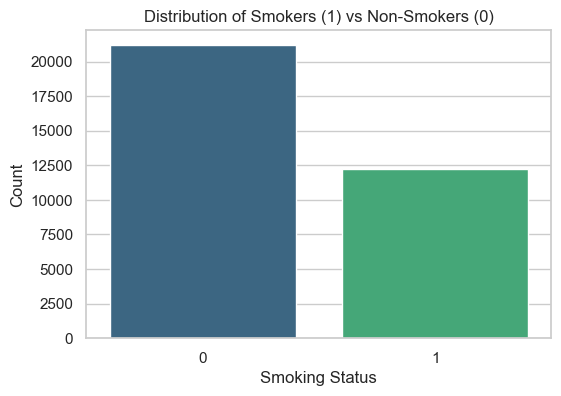

Class Ratio:
smoking
0    0.633729
1    0.366271
Name: proportion, dtype: float64


In [ ]:
# 2. Class Balance Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='smoking', data=df, palette='viridis')
plt.title('Distribution of Smokers (1) vs Non-Smokers (0)')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

ratio = df['smoking'].value_counts(normalize=True)
print(f"Class Ratio:\n{ratio}")


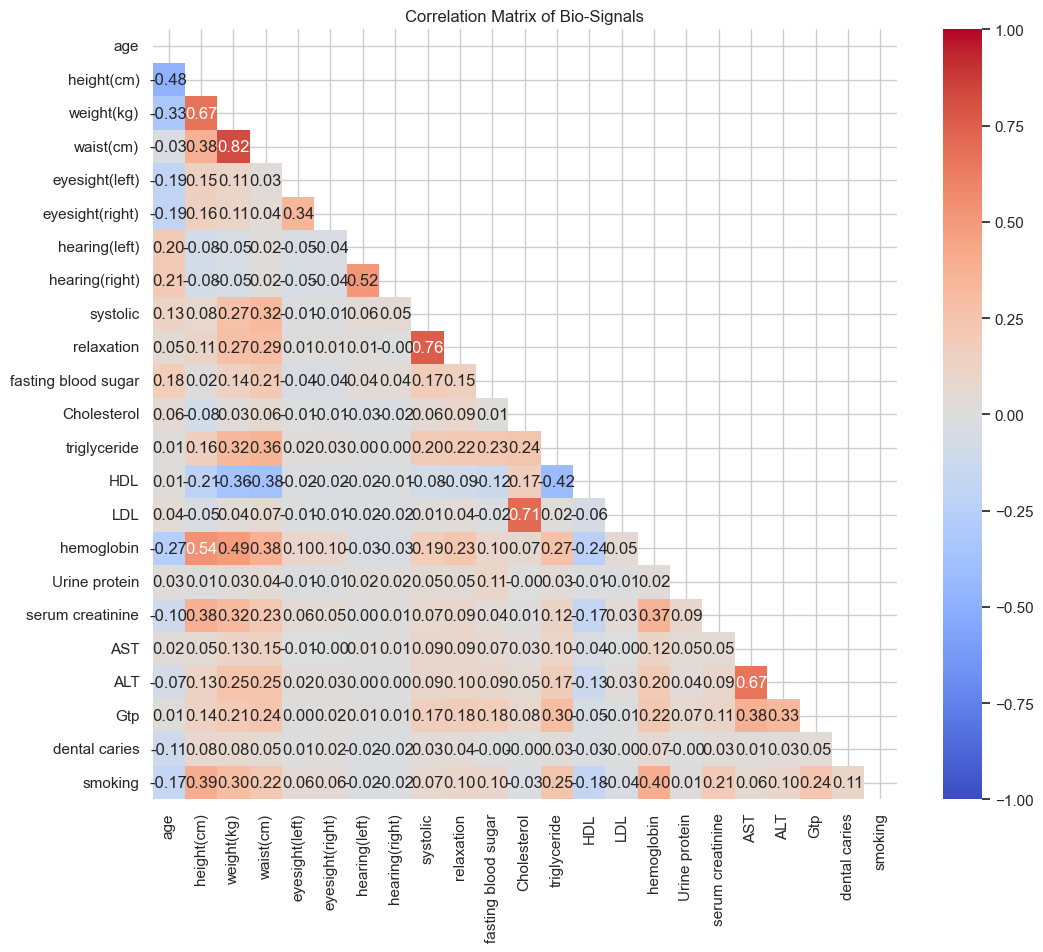

In [ ]:
# --- A. Correlation Heatmap ---
plt.figure(figsize=(12, 10))

# Calculate correlation only on numeric columns
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Create a mask to hide the upper triangle (it's symmetrical/redundant)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Bio-Signals')
plt.show()

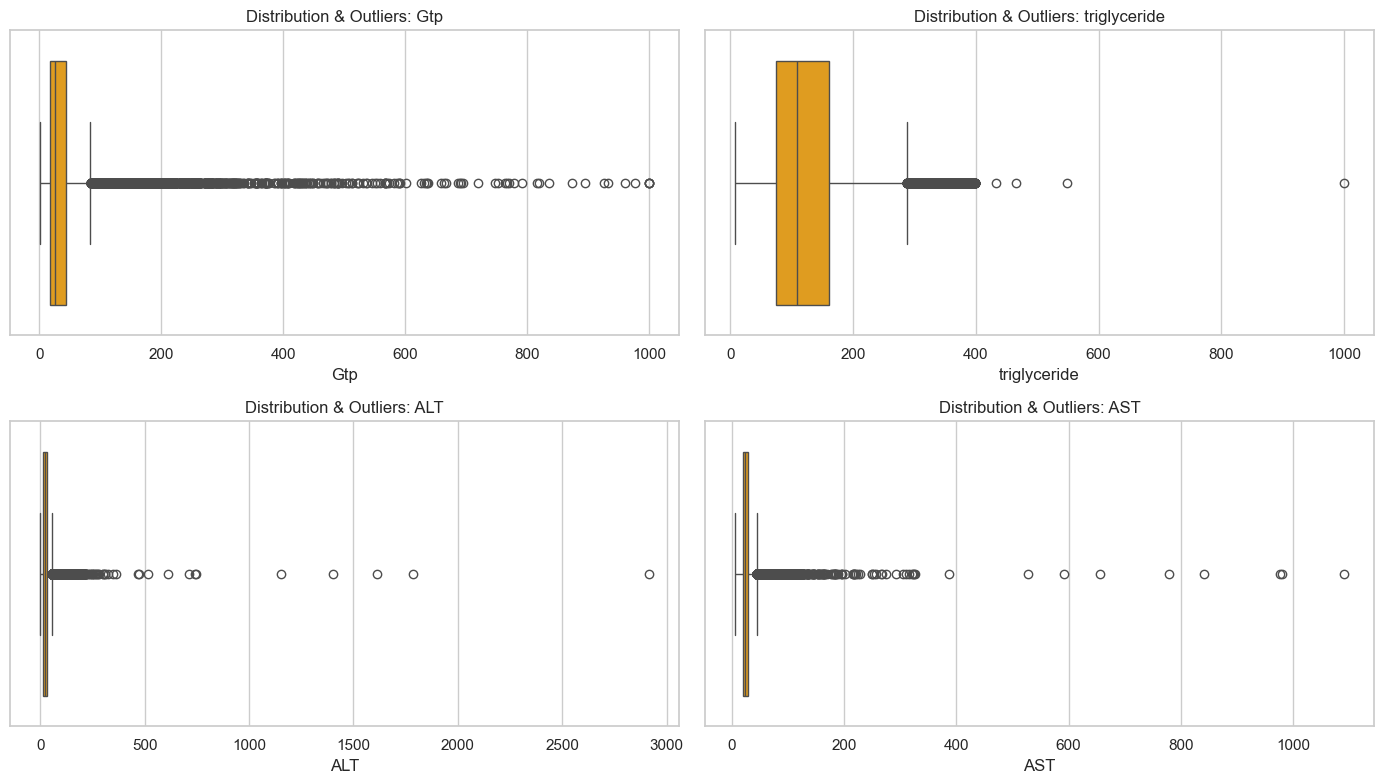

In [ ]:
# --- B. Outlier Visualization (Boxplots) ---
# We focus on features known to have extreme values in this dataset
outlier_features = ['Gtp', 'triglyceride', 'ALT', 'AST']

plt.figure(figsize=(14, 8))
for i, col in enumerate(outlier_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'Distribution & Outliers: {col}')
plt.tight_layout()
plt.show()

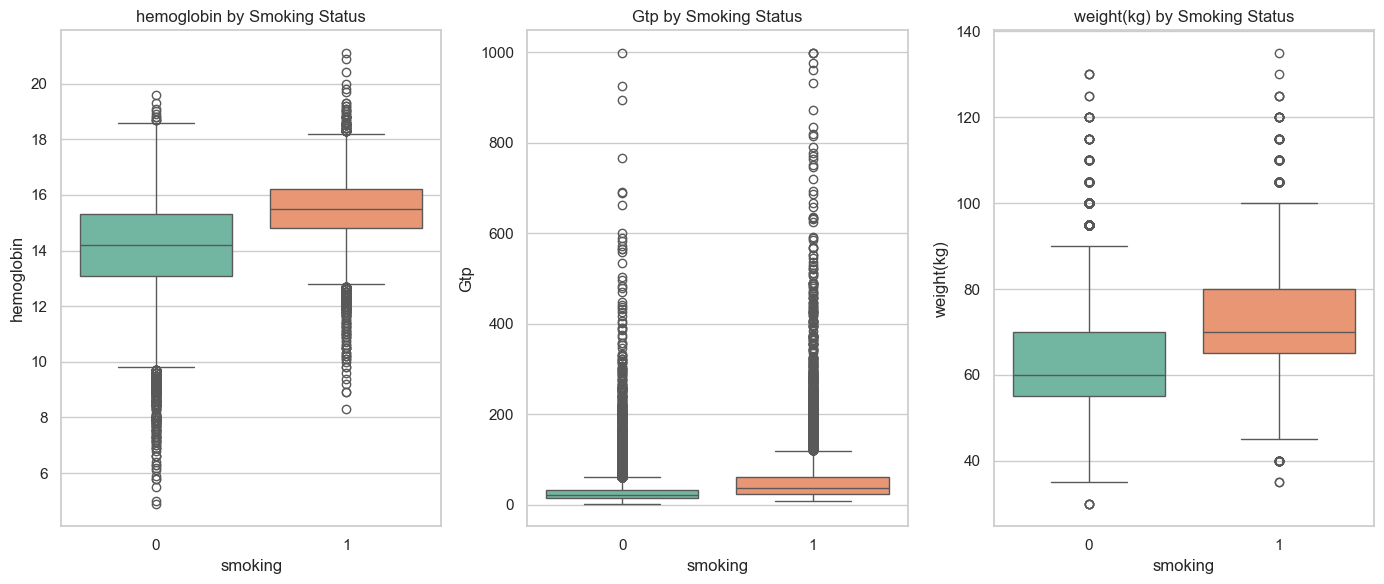

In [ ]:
# --- C. Compare "Signals" (Smoker vs Non-Smoker) ---
# This proves if the data actually contains predictive signals
signal_features = ['hemoglobin', 'Gtp', 'weight(kg)']

plt.figure(figsize=(14, 6))
for i, col in enumerate(signal_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='smoking', y=col, data=df, palette='Set2')
    plt.title(f'{col} by Smoking Status')
plt.tight_layout()
plt.show()

In [ ]:
# --- 2. Feature Engineering (Crucial for High Accuracy) ---
# Create BMI (Standard medical metric better than raw height/weight)
# Height is in cm, so convert to meters
df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)

# Create Pulse Pressure (Captures the gap between systolic/relaxation)
df['Pulse_Pressure'] = df['systolic'] - df['relaxation']

# Drop highly correlated/redundant columns to help Logistic Regression
# We drop 'waist(cm)' because it correlates 0.82 with weight
# We drop 'systolic' and 'relaxation' because we captured their relationship in Pulse_Pressure
drop_cols = ['waist(cm)', 'systolic', 'relaxation'] 
df_clean = df.drop(columns=drop_cols)

print(f"New Feature Set: {df_clean.columns.tolist()}")
print(f"Total columns: {len(df_clean.columns)}")

New Feature Set: ['age', 'height(cm)', 'weight(kg)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking', 'BMI', 'Pulse_Pressure']
Total columns: 22


In [ ]:
# --- 3. Outlier Handling (Log Transformation) ---
# The outliers in Gtp, ALT, and AST were massive. Log transform pulls them in.
# We add +1 to avoid log(0) errors
outlier_cols = ['Gtp', 'ALT', 'AST', 'triglyceride']
for col in outlier_cols:
    df_clean[col] = np.log1p(df_clean[col])

In [ ]:
# --- 4. Train/Test Split ---
X = df_clean.drop('smoking', axis=1)
y = df_clean['smoking']

# Stratify ensures we keep the same smoker/non-smoker ratio in test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 5. Scaling ---
# We use StandardScaler now that we have fixed the outliers with Log transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training Random Forest for feature importance analysis...


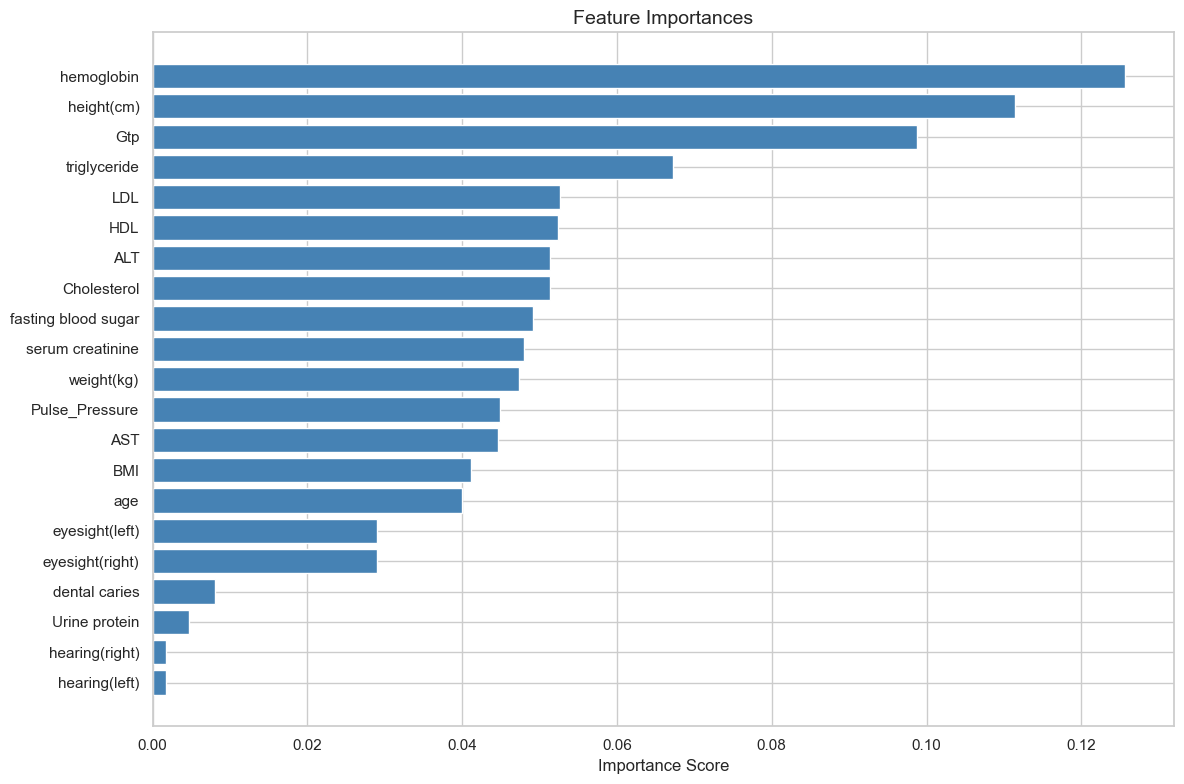


Top 10 Most Important Features:
1. hemoglobin: 0.1257
2. height(cm): 0.1114
3. Gtp: 0.0988
4. triglyceride: 0.0672
5. LDL: 0.0527
6. HDL: 0.0524
7. ALT: 0.0514
8. Cholesterol: 0.0513
9. fasting blood sugar: 0.0491
10. serum creatinine: 0.0480

Computing permutation importance (this may take a minute)...


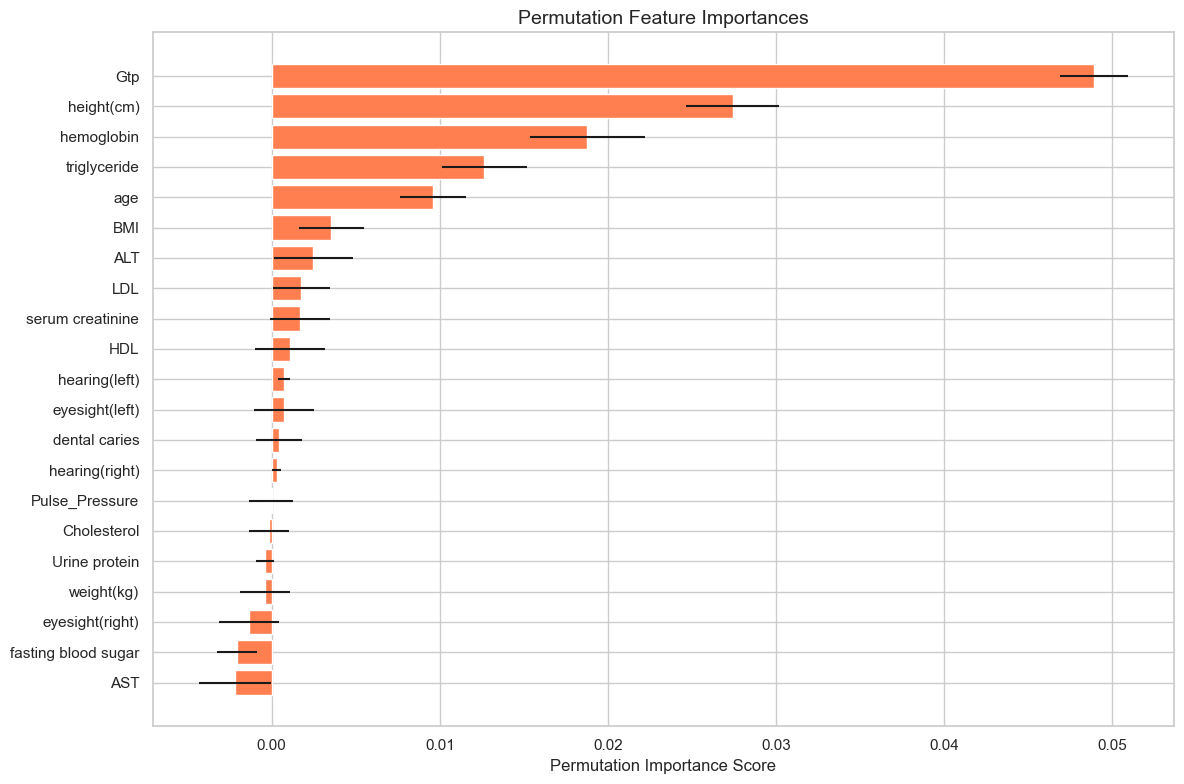


Top 10 Features by Permutation Importance:
1. Gtp: 0.0489 (±0.0020)
2. height(cm): 0.0274 (±0.0028)
3. hemoglobin: 0.0188 (±0.0034)
4. triglyceride: 0.0127 (±0.0025)
5. age: 0.0096 (±0.0020)
6. BMI: 0.0036 (±0.0019)
7. ALT: 0.0025 (±0.0023)
8. LDL: 0.0018 (±0.0017)
9. serum creatinine: 0.0017 (±0.0018)
10. HDL: 0.0011 (±0.0021)

Suggested top features: ['Gtp', 'height(cm)', 'hemoglobin', 'triglyceride', 'age', 'BMI', 'ALT', 'LDL', 'serum creatinine', 'HDL', 'hearing(left)', 'eyesight(left)', 'dental caries', 'hearing(right)', 'Pulse_Pressure']


In [31]:
# --- Feature Importance Analysis ---
# This helps identify which features are most predictive for smoking status

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Train a quick Random Forest to get feature importances
print("Training Random Forest for feature importance analysis...")
rf_temp = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced')
rf_temp.fit(X_train_scaled, y_train)

# Get feature importances
feature_names = X_train.columns
importances = rf_temp.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances", fontsize=14)
plt.barh(range(len(importances)), importances[indices], color='steelblue')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
for i in range(min(10, len(indices))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Permutation importance (more reliable, but slower)
print("\nComputing permutation importance (this may take a minute)...")
perm_importance = permutation_importance(rf_temp, X_test_scaled, y_test, n_repeats=10, 
                                         random_state=RANDOM_STATE, n_jobs=-1)

# Plot permutation importance
perm_indices = np.argsort(perm_importance.importances_mean)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Permutation Feature Importances", fontsize=14)
plt.barh(range(len(perm_importance.importances_mean)), 
         perm_importance.importances_mean[perm_indices], 
         xerr=perm_importance.importances_std[perm_indices],
         color='coral')
plt.yticks(range(len(perm_indices)), [feature_names[i] for i in perm_indices])
plt.xlabel('Permutation Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Permutation Importance:")
for i in range(min(10, len(perm_indices))):
    idx = perm_indices[i]
    print(f"{i+1}. {feature_names[idx]}: {perm_importance.importances_mean[idx]:.4f} "
          f"(±{perm_importance.importances_std[idx]:.4f})")

# Optional: You can use this information to select top features if needed
top_features = [feature_names[i] for i in perm_indices[:15]]  # Top 15 features
print(f"\nSuggested top features: {top_features}")


In [32]:
# --- Logistic Regression ---
print("Training Logistic Regression...")

# Balance Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Grid Search
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=3000), 
    param_grid, cv=5, scoring='accuracy'
)
grid_lr.fit(X_train_smote, y_train_smote)

best_lr = grid_lr.best_estimator_
acc_lr = accuracy_score(y_test, best_lr.predict(X_test_scaled))

print(f"Best Params: {grid_lr.best_params_}")
print(f"LogReg Accuracy: {acc_lr:.4f}")

Training Logistic Regression...
Best Params: {'C': 10, 'solver': 'liblinear'}
LogReg Accuracy: 0.7257


In [33]:
# ------------------ SVM with RandomizedSearchCV (FAST) ------------------
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

print("Applying SMOTE to training data for SVM (fast version)...")
smote_svm_fast = SMOTE(random_state=RANDOM_STATE)
X_train_svm_smote_fast, y_train_svm_smote_fast = smote_svm_fast.fit_resample(X_train_scaled, y_train)
print(f"Training shape after SMOTE: {X_train_svm_smote_fast.shape}")

# Subsample for faster tuning
print("\nSampling 50% of SMOTE data for tuning...")
X_tune, y_tune = resample(
    X_train_svm_smote_fast, y_train_svm_smote_fast,
    n_samples=len(X_train_svm_smote_fast) // 2,
    random_state=RANDOM_STATE,
    stratify=y_train_svm_smote_fast,
)
print(f"Tuning on sample: {X_tune.shape}")

# Lean search space
param_grid_svm_fast = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

# RandomizedSearchCV for speed
random_svm = RandomizedSearchCV(
    SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced'),
    param_distributions=param_grid_svm_fast,
    n_iter=12,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
)
random_svm.fit(X_tune, y_tune)

print("\nBest SVM Parameters (sample tuning):")
print(random_svm.best_params_)
print(f"Best CV ROC AUC (sample): {random_svm.best_score_:.4f}")

# Retrain on full SMOTE data
print("\nRetraining best model on FULL SMOTE data...")
best_svm = SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced',
               **random_svm.best_params_)
best_svm.fit(X_train_svm_smote_fast, y_train_svm_smote_fast)
print("Final SVM trained on full data.")

# Evaluate
y_pred_svm = best_svm.predict(X_test_scaled)
y_proba_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

print("\n--- SVM Results (FAST) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_svm):.4f}")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens')
plt.title(f'SVM Confusion Matrix (Acc={accuracy_score(y_test, y_pred_svm):.4f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, label=f'ROC AUC = {roc_auc_score(y_test, y_proba_svm):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve (FAST)')
plt.legend()
plt.show()


Applying SMOTE to training data for SVM (fast version)...
Training shape after SMOTE: (33934, 21)

Sampling 50% of SMOTE data for tuning...
Tuning on sample: (16967, 21)
Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

Training Neural Network...
Epoch 1/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7091 - loss: 0.5474 - val_accuracy: 0.8329 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 2/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7307 - loss: 0.5042 - val_accuracy: 0.7311 - val_loss: 0.6035 - learning_rate: 0.0010
Epoch 3/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7377 - loss: 0.4953 - val_accuracy: 0.7108 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 4/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7409 - loss: 0.4915 - val_accuracy: 0.6782 - val_loss: 0.6372 - learning_rate: 0.0010
Epoch 5/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7436 - loss: 0.4893 - val_accuracy: 0.7171 - val_loss: 0.6121 - learning_rate: 0.0010
Epoch 6/100
825/849 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7411 - loss: 0.4895
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - ac

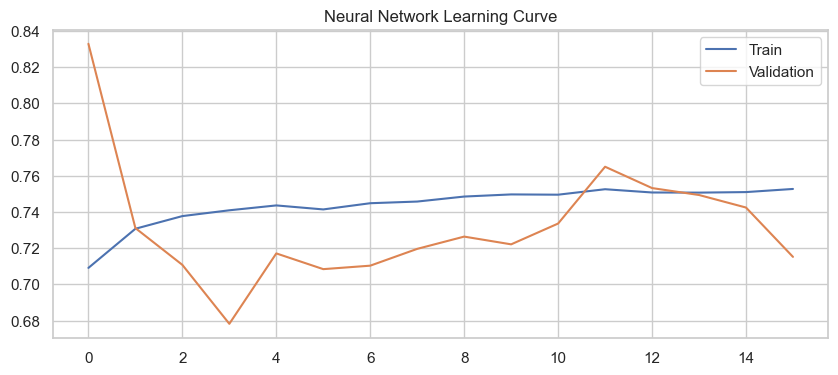

In [35]:
# --- Cell 6: Neural Network ---
print("Training Neural Network...")

# 1. Balance Data for NN
smote = SMOTE(random_state=42)
X_train_nn, y_train_nn = smote.fit_resample(X_train_scaled, y_train)

# 2. Build Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')
])

# 3. Compile
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# 4. Callbacks (Auto-Tuning)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

# 5. Train
history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 6. Evaluate
loss, acc_nn = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Network Accuracy: {acc_nn:.4f}")

# Plot History
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Neural Network Learning Curve")
plt.legend()
plt.show()

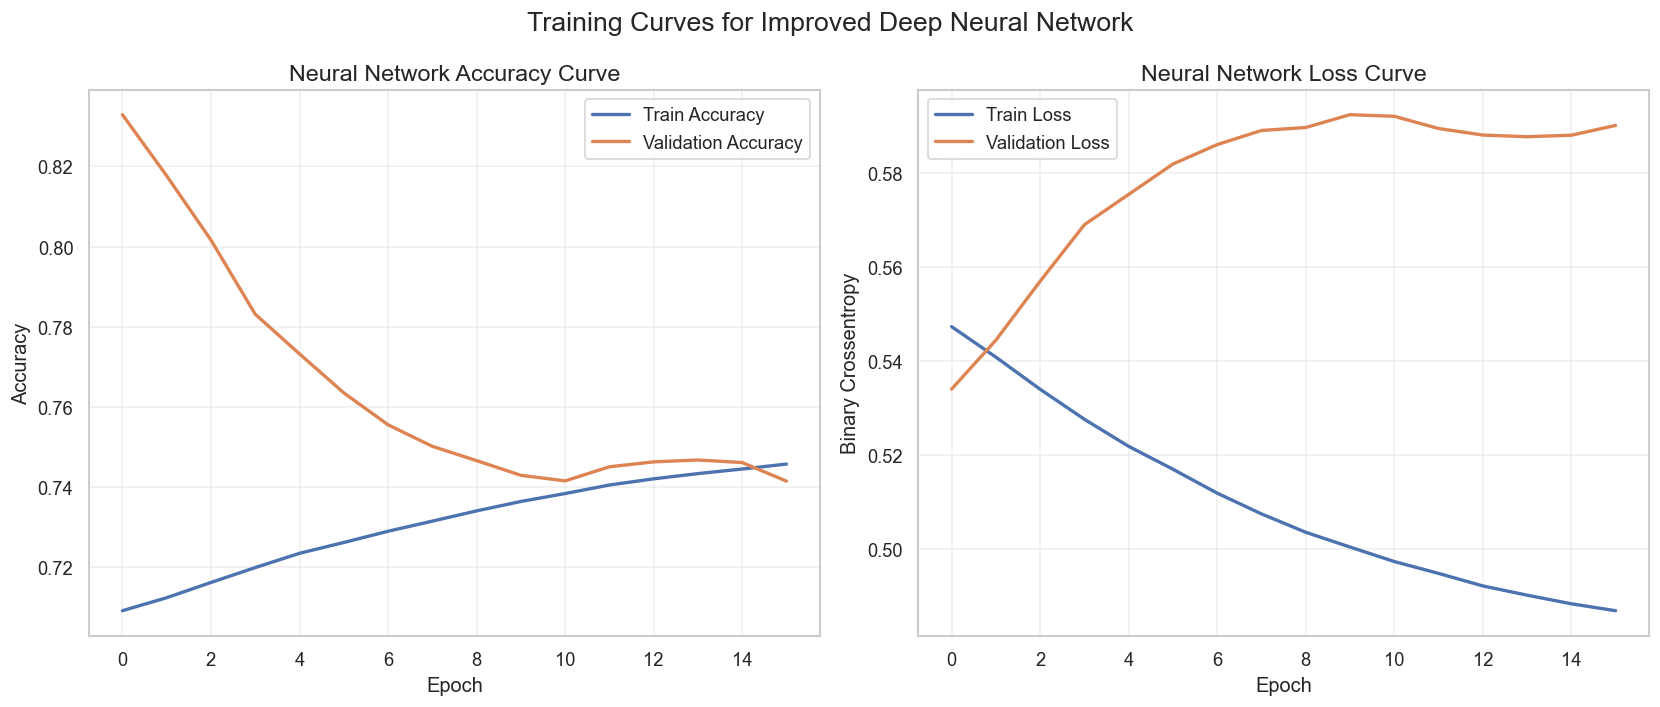

In [36]:
def smooth(values, weight=0.85):
    """Smooth curves for cleaner visualization."""
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Smooth curves
acc_s = smooth(acc)
val_acc_s = smooth(val_acc)
loss_s = smooth(loss)
val_loss_s = smooth(val_loss)

plt.figure(figsize=(14, 6), dpi=120)

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc_s, label="Train Accuracy", linewidth=2)
plt.plot(val_acc_s, label="Validation Accuracy", linewidth=2)
plt.title("Neural Network Accuracy Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss_s, label="Train Loss", linewidth=2)
plt.plot(val_loss_s, label="Validation Loss", linewidth=2)
plt.title("Neural Network Loss Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Binary Crossentropy", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

plt.suptitle("Training Curves for Improved Deep Neural Network", fontsize=16)
plt.tight_layout()
plt.show()